<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/larissa_santesso/Aula_6_Exerc%C3%ADcio_Larissa_Santesso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [ ]:
nome = "Larissa Antonelli Santesso"

print(f'Meu nome é {nome}')

Meu nome é Larissa Antonelli Santesso


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [ ]:
batch_size = 50

## Download do CIFAR-10

In [ ]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Criação do dataloader

In [ ]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

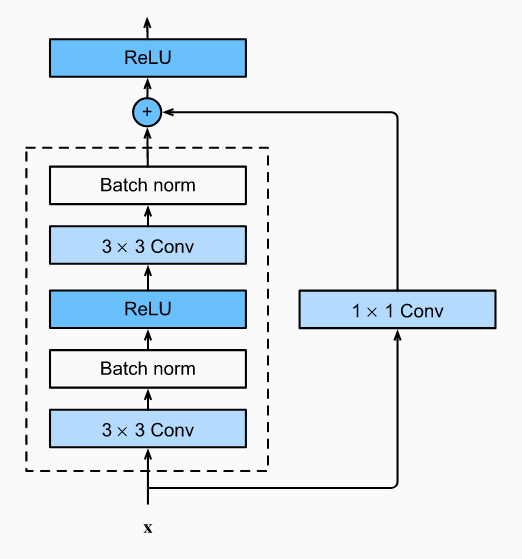

https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html

In [ ]:
from torch import nn
from torch import Tensor

class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        
        # Código baseado no código fonte do BasicBlock do pytorch

        self.conv1 =nn.Conv2d(inplanes, planes,kernel_size=3, stride=stride, padding=1, dilation=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, bias=False, padding=1, dilation=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        
        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [ ]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [ ]:
from collections import OrderedDict

class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()

        self.dense_len = 4*4*128
        # Camadas Convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            ('block1', MyBasicBlock(inplanes=3, planes=32, stride=1)),
            ('block2', MyBasicBlock(inplanes=32, planes=64, stride=1)),
            ('avg_pool1', nn.AvgPool2d(2, stride=2)),
            ('block3', MyBasicBlock(inplanes=64, planes=64, stride=1)),
            ('avg_pool2', nn.AvgPool2d(2, stride=2)),
            ('block4', MyBasicBlock(inplanes=64, planes=128, stride=1)),
            ('block5', MyBasicBlock(inplanes=128, planes=128, stride=1)),
            ('avg_pool3', nn.AvgPool2d(2, stride=2)),       
            ]))

         # Camadas densas
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(self.dense_len, 512)),
            ('relu1',  nn.ReLU()),
            ('dense2', nn.Linear(512, 10)),
        ]))
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, self.dense_len)  # Transforma a imagem em vetor
        out = self.dense_layer(out)

        return out

## Treinamento

### Definição dos hiperparâmetros

In [ ]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm

In [ ]:
def evaluation(model, loader):
    corrects = 0.0
    total = 0.0
    
    model.eval()
    with torch.no_grad():
        for x_eval, y_eval in tqdm(loader,total=len(loader), desc='Evaluation'):
            x_eval = x_eval.to(device)
            # forward - predict
            out = model(x_eval)
            
            probs = torch.softmax(out, dim=1).cpu()
            preds = probs.argmax(dim=1)
            corrects += (preds == y_eval).sum().item()
            total += y_eval.size(0)

    mean_accuracy = corrects / total
    
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [ ]:
from tqdm.notebook import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.102


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 0/19 Loss: 0.9399057030677795


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.556


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 1/19 Loss: 0.7609245181083679


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.6958


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 2/19 Loss: 0.7838600277900696


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.7156


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 3/19 Loss: 0.6781635880470276


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.6996


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 4/19 Loss: 0.5929877758026123


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.768


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 5/19 Loss: 0.4916670620441437


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.7628


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 6/19 Loss: 0.1792672574520111


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8101


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 7/19 Loss: 0.26860567927360535


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.7982


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 8/19 Loss: 0.2384830266237259


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.7975


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 9/19 Loss: 0.1864132285118103


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8077


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 10/19 Loss: 0.06628582626581192


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8123


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 11/19 Loss: 0.3590250313282013


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.7856


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 12/19 Loss: 0.1973673403263092


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8111


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 13/19 Loss: 0.17225982248783112


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8191


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 14/19 Loss: 0.10257195681333542


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.826


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 15/19 Loss: 0.04346560314297676


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8257


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 16/19 Loss: 0.012571963481605053


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8399


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 17/19 Loss: 0.0028466677758842707


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8483


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 18/19 Loss: 0.003480362007394433


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8509


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 19/19 Loss: 0.0038777682930231094


Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8532


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

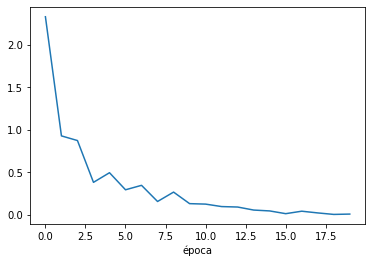

In [ ]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [ ]:
evaluation(model=model, loader=test_dataloader)

Evaluation:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8547


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        super(MyDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError(f"dropout probability has to be between 0 and 1, but got {p}")
        self.p = p
        
    def forward(self, x: Tensor, training: bool):
        if training:
            bernoulli = torch.distributions.bernoulli.Bernoulli(probs=1.0-self.p) # dropout invertido

            return x * bernoulli.sample(x.size()) * (1.0/(1-self.p))

        return x

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.5027669072151184
mean zeros pytorch: 0.4972737729549408


In [ ]:
out.shape

torch.Size([16, 3, 32, 32])

In [ ]:
target_out.shape

torch.Size([16, 3, 32, 32])

In [ ]:
x

tensor([[[[6.6371e-01, 1.2508e-01, 8.9282e-01,  ..., 3.0118e-01,
           9.3199e-01, 3.3323e-01],
          [4.4774e-01, 3.3064e-01, 3.6061e-01,  ..., 1.5629e-02,
           2.4973e-01, 4.3567e-01],
          [9.2421e-01, 6.4839e-01, 4.8338e-01,  ..., 3.9448e-01,
           6.6963e-02, 6.2698e-01],
          ...,
          [6.1615e-01, 9.4487e-01, 8.4744e-03,  ..., 3.2457e-01,
           8.5051e-01, 1.6334e-01],
          [2.3023e-01, 3.2794e-02, 5.1467e-01,  ..., 4.6190e-01,
           9.8759e-01, 3.7471e-01],
          [2.9445e-02, 4.3222e-01, 4.8182e-02,  ..., 6.1406e-01,
           7.9755e-01, 4.8775e-01]],

         [[5.0961e-01, 6.0216e-01, 2.5930e-01,  ..., 4.8153e-01,
           9.9210e-01, 5.1671e-01],
          [4.6000e-01, 3.4713e-01, 4.6102e-02,  ..., 6.2094e-01,
           9.7511e-01, 9.0285e-01],
          [8.2918e-01, 5.3970e-01, 7.9693e-01,  ..., 7.0332e-01,
           9.8250e-02, 1.8059e-01],
          ...,
          [1.4109e-01, 9.3404e-01, 4.0295e-02,  ..., 3.8356

In [ ]:
target_out

tensor([[[[6.6371e-01, 1.2508e-01, 8.9282e-01,  ..., 3.0118e-01,
           9.3199e-01, 3.3323e-01],
          [4.4774e-01, 3.3064e-01, 3.6061e-01,  ..., 1.5629e-02,
           2.4973e-01, 4.3567e-01],
          [9.2421e-01, 6.4839e-01, 4.8338e-01,  ..., 3.9448e-01,
           6.6963e-02, 6.2698e-01],
          ...,
          [6.1615e-01, 9.4487e-01, 8.4744e-03,  ..., 3.2457e-01,
           8.5051e-01, 1.6334e-01],
          [2.3023e-01, 3.2794e-02, 5.1467e-01,  ..., 4.6190e-01,
           9.8759e-01, 3.7471e-01],
          [2.9445e-02, 4.3222e-01, 4.8182e-02,  ..., 6.1406e-01,
           7.9755e-01, 4.8775e-01]],

         [[5.0961e-01, 6.0216e-01, 2.5930e-01,  ..., 4.8153e-01,
           9.9210e-01, 5.1671e-01],
          [4.6000e-01, 3.4713e-01, 4.6102e-02,  ..., 6.2094e-01,
           9.7511e-01, 9.0285e-01],
          [8.2918e-01, 5.3970e-01, 7.9693e-01,  ..., 7.0332e-01,
           9.8250e-02, 1.8059e-01],
          ...,
          [1.4109e-01, 9.3404e-01, 4.0295e-02,  ..., 3.8356

In [ ]:
out

tensor([[[[6.6371e-01, 1.2508e-01, 8.9282e-01,  ..., 3.0118e-01,
           9.3199e-01, 3.3323e-01],
          [4.4774e-01, 3.3064e-01, 3.6061e-01,  ..., 1.5629e-02,
           2.4973e-01, 4.3567e-01],
          [9.2421e-01, 6.4839e-01, 4.8338e-01,  ..., 3.9448e-01,
           6.6963e-02, 6.2698e-01],
          ...,
          [6.1615e-01, 9.4487e-01, 8.4744e-03,  ..., 3.2457e-01,
           8.5051e-01, 1.6334e-01],
          [2.3023e-01, 3.2794e-02, 5.1467e-01,  ..., 4.6190e-01,
           9.8759e-01, 3.7471e-01],
          [2.9445e-02, 4.3222e-01, 4.8182e-02,  ..., 6.1406e-01,
           7.9755e-01, 4.8775e-01]],

         [[5.0961e-01, 6.0216e-01, 2.5930e-01,  ..., 4.8153e-01,
           9.9210e-01, 5.1671e-01],
          [4.6000e-01, 3.4713e-01, 4.6102e-02,  ..., 6.2094e-01,
           9.7511e-01, 9.0285e-01],
          [8.2918e-01, 5.3970e-01, 7.9693e-01,  ..., 7.0332e-01,
           9.8250e-02, 1.8059e-01],
          ...,
          [1.4109e-01, 9.3404e-01, 4.0295e-02,  ..., 3.8356